In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py
import cv2
from matplotlib import pyplot as plt

import pathlib
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Will use {}'.format(device))

Will use cuda


In [3]:
train_data_hf =  h5py.File('train_catvnoncat.h5', 'r')
print(train_data_hf.keys())
train_x = torch.tensor(train_data_hf.get('train_set_x'))
train_y = torch.tensor(train_data_hf.get('train_set_y'))

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


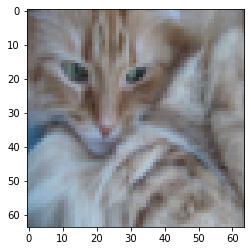

In [4]:
plt.imshow(train_x[2])

In [5]:
train_x = train_x.to(device)
train_y = train_y.to(device)

In [6]:
m_train,w,h,c = train_x.shape
n = w*h*c

In [7]:
train_x = train_x.reshape(m_train,n)
train_y = train_y.reshape(m_train,1)
train_x.shape, train_y.shape

(torch.Size([209, 12288]), torch.Size([209, 1]))

In [8]:
train_x = train_x/255

In [9]:
learning_rate = 0.0075
epochs = 2000

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12288, 7)
        self.fc2 = nn.Linear(7, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [11]:
classifier = Model().to(device)
optimizer = optim.SGD(classifier.parameters(),lr=learning_rate)
losses=[]

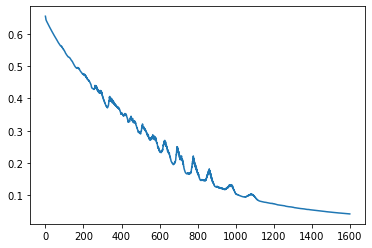

In [12]:
for i in range(1600):
    classifier.zero_grad()
    y_hat = classifier(train_x)
    loss = F.binary_cross_entropy(y_hat.float(),train_y.float())
    losses.append(loss)
    loss.backward()
    optimizer.step()
plt.plot(losses)

In [13]:
loss

tensor(0.0422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [14]:
out = classifier(train_x) > 0.5
out = out.int()

In [15]:
train_acc = torch.sum(train_y*out)/torch.sum(train_y)
print('Train Accuracy: {0}'.format(float(train_acc)))

Train Accuracy: 1.0


In [16]:
test_data_hf = h5py.File('test_catvnoncat.h5','r')
test_x = torch.tensor(test_data_hf.get('test_set_x'),dtype=torch.float)
test_y = torch.tensor(test_data_hf.get('test_set_y'),dtype=torch.float)

In [17]:
m_test,w,h,c = test_x.shape
test_x = test_x.reshape(m_test,w*h*c)
test_y = test_y.reshape(m_test,1)

In [18]:
test_x = test_x.to(device)
test_y = test_y.to(device)

In [19]:
out_test = classifier(test_x)>0.5
out_test = out_test.int()

In [20]:
comp = out_test==test_y
comp = comp.int()
comp = torch.sum(comp)
test_acc = int(comp)/m_test
print('Test accuracy: {} \nMatched: {}'.format(test_acc,comp))

Test accuracy: 0.72 
Matched: 36


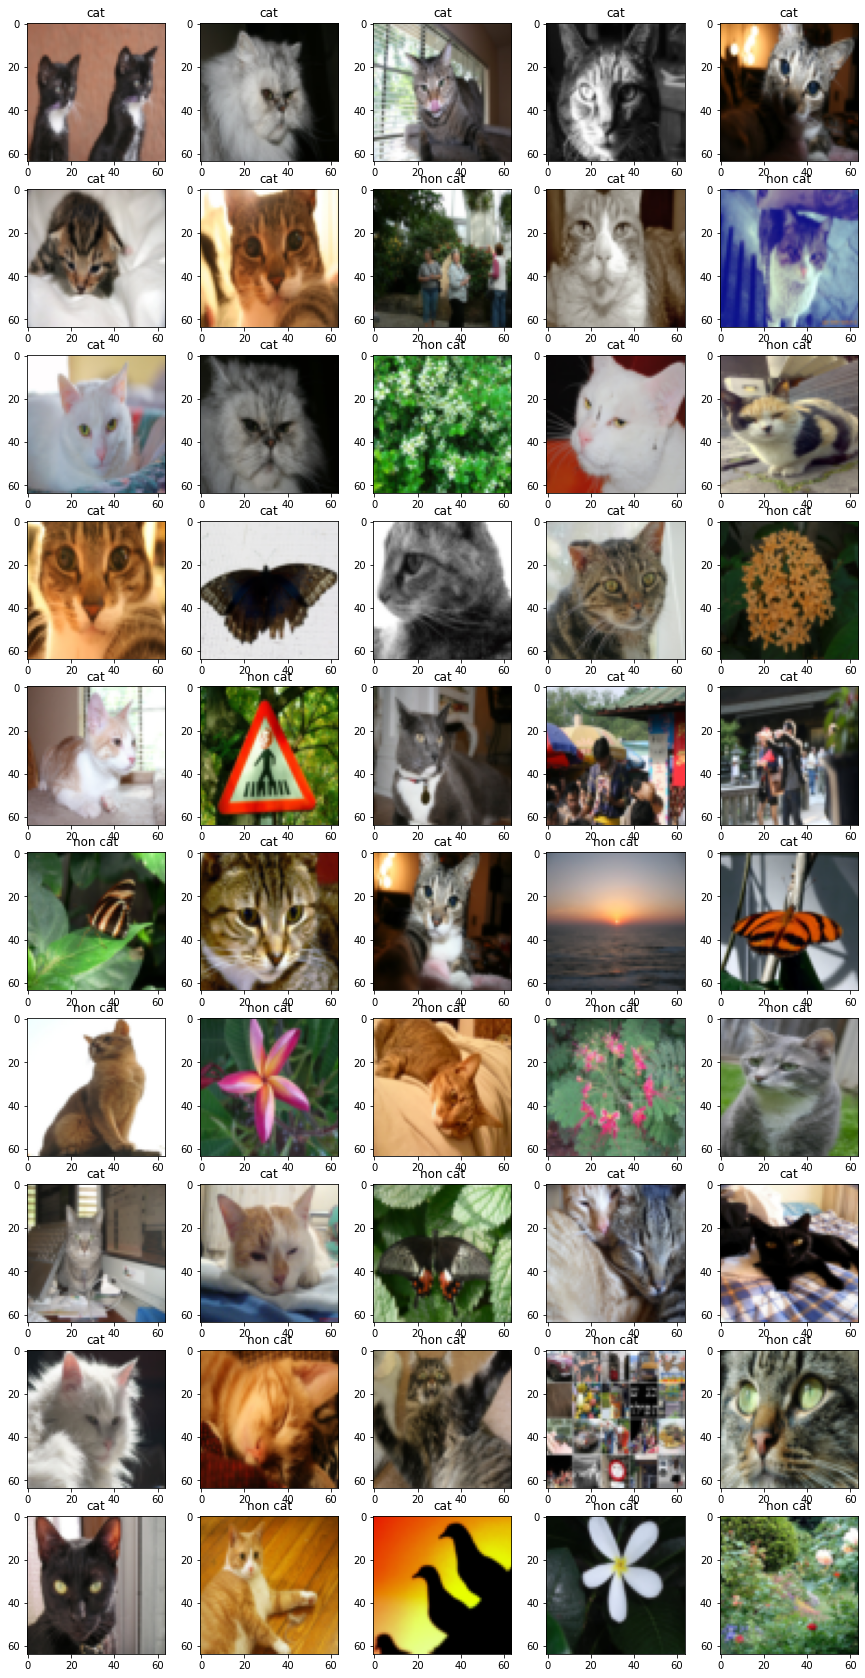

In [21]:
fig,ax = plt.subplots(10,5,figsize=(15,30))
for j in range(10):
    for i in range(5):
        title = 'cat' if out_test[i*10 + j] ==1 else 'non cat'
        ax[j][i].title.set_text(title)
        ax[j][i].imshow(test_data_hf.get('test_set_x')[i*10 + j])

In [22]:
class Model2(nn.Module):
    def __init__(self,features):
        super().__init__()
        self.Z1 = nn.Linear(features,20)
        self.Z2 = nn.Linear(20,7)
        self.Z3 = nn.Linear(7,5)
        self.Z4 = nn.Linear(5,1)
    
    def forward(self,X):
        temp = F.relu(self.Z1(X))
        temp = F.relu(self.Z2(temp))
        temp = F.relu(self.Z3(temp))
        temp = torch.sigmoid(self.Z4(temp))
        return temp

In [23]:
classifier2 = Model2(n).to(device)
losses2 = []

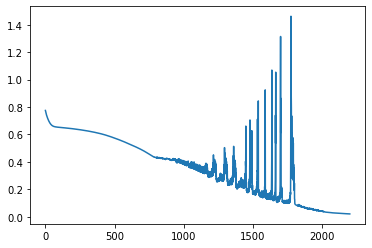

In [24]:
for i in range(2200):
    classifier2.zero_grad()
    out2 = classifier2(train_x)
    optimizer2 = optim.SGD(classifier2.parameters(),lr=0.007)
    loss2 = F.binary_cross_entropy(out2,train_y.float())
    losses2.append(loss2)
    loss2.backward()
    optimizer2.step()
plt.plot(losses2)

In [25]:
loss2

tensor(0.0206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [26]:
out2 = out2>0.05
out2 = out2.int()

comp = out2==train_y
comp = comp.int()
comp = torch.sum(comp)
train_acc = comp/m_train
print('Train accuracy: {}'.format(train_acc))

Train accuracy: 0.9665071368217468


In [27]:
out2_test = classifier2(test_x)
out2_test = out2_test.int()
comp = out2_test==test_y
comp = torch.sum(comp)
print('Test accuracy: {}'.format(float(comp)/m_test))

Test accuracy: 0.76
